# Assignment 2: Segmentation from Superpixels

Name: **Naitri Rajyaguru**

UID:  **117361919**

Link to Google Drive : **View-only Link to Notebook Here (make sure it works)**

Please submit a PDF containing all outputs to gradescope by **November 30, 3:30pm**




The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite open-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 



Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

## Data
First, we download the MSRC labeled imaged database.

In [1]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2022-11-16 07:44:55--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.50.228.186, 2600:1408:20:c9c::317f, 2600:1408:20:c84::317f, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.50.228.186|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2022-11-16 07:44:55--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|23.50.228.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M

We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.

In [2]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

Before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

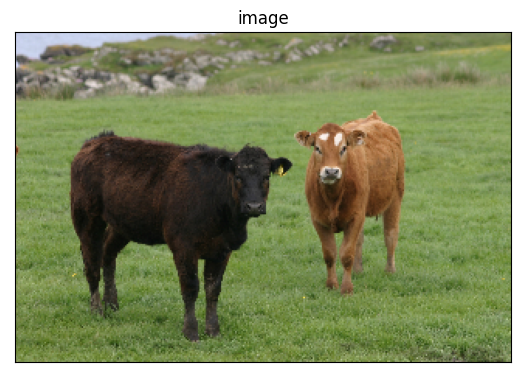

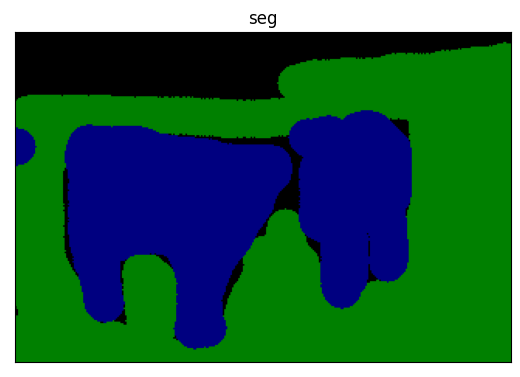

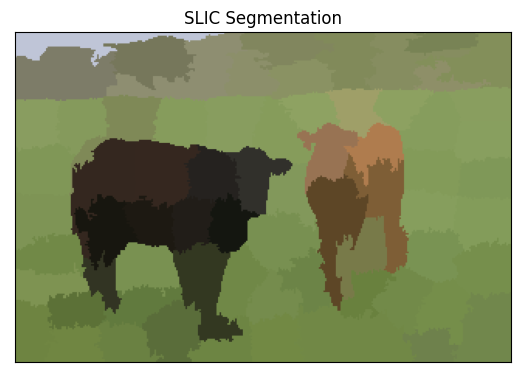

In [3]:


#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")



In [4]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os

from tqdm import tqdm
import pandas as pd

current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'



In [5]:


## Create the train, test directories

def make_dir(directory):
  dir_path = os.path.join(msrc_directory, directory)
  if not os.path.exists(dir_path):
    os.mkdir(dir_path)
  return dir_path


datasets_dir = 'datasets'
train_dir = 'datasets/train'
test_dir = 'datasets/test'
datasets_path = os.path.join(msrc_directory, datasets_dir)
if not os.path.exists(datasets_path):
  os.mkdir(datasets_path)


datasets_path = make_dir(datasets_dir)
train_path = make_dir(train_dir)
test_path = make_dir(test_dir)



In [6]:


#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']
    label_2_rgb[i['id']] = i['rgb_values']



## Question 1: Superpixel Dataset (30 points) 

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>




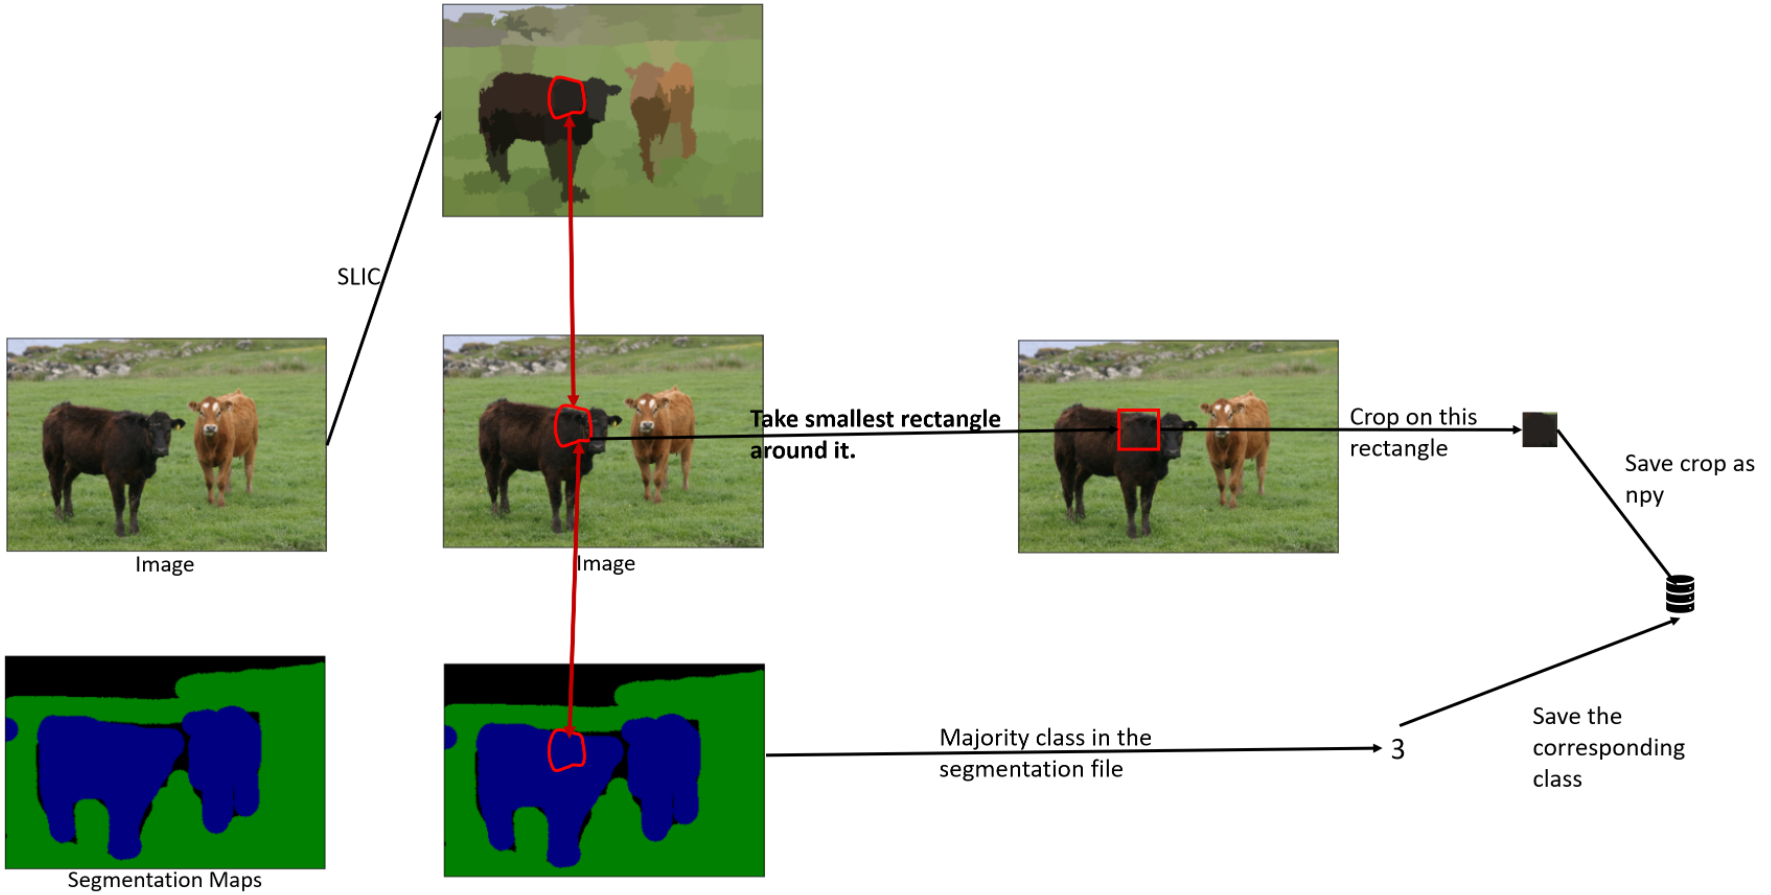

In [7]:


## All the global constants:

#Image pre-processing
GT = '_GT'
BMP_EXT = '.bmp'
NPY = '.npy'
NUM_SLIC_SEG = 100

#train and test files
TRAIN_DIR = 'train'
TEST_DIR = 'test'
TRAIN_TEXTFILE = 'train.txt'
TEST_TEXTFILE = 'test.txt'

TRAIN_CSVFILE = 'train.csv'
TEST_CSVFILE = 'test.csv'

NUM_WORKERS = 2

# data transformers
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


# hyperparams
NUM_EPOCH = 5
BATCH_SIZE = 16
LEARNING_RATE = 1e-4



In [8]:
def get_rect_patch(index_list):
  y_list = index_list[0]
  x_list = index_list[1]
  x_min, x_max = min(x_list), max(x_list)
  y_min, y_max = min(y_list), max(y_list)
  return x_min, x_max, y_min, y_max


def dilate_rect_patch(rect_patch_loc, H, W, num_pix=3):
  x_min, x_max, y_min, y_max = rect_patch_loc
  
  x_min = max(0, x_min - num_pix)
  y_min = max(0, y_min - num_pix)

  x_max = min(W, x_max + num_pix)
  y_max = max(H, y_max + num_pix)

  return x_min, x_max, y_min, y_max


def get_rect_patch_loc(seg_map, seg_label):
  H, W = seg_map.shape
  seg_label_ind = np.where(seg_map == seg_label)
  if len(seg_label_ind[0]) == 0:
    return None

  rect_patch_loc = get_rect_patch(seg_label_ind)

  ## dilate the superpixel / rectangle
  rect_patch_loc = dilate_rect_patch(rect_patch_loc, H, W)
  return rect_patch_loc


def crop_image(image, rect_patch_loc):
  x_min, x_max, y_min, y_max = rect_patch_loc
  cropped_image = image[y_min:y_max, x_min:x_max, :]
  return cropped_image

def get_gt_seg_class(gt_image_patch):
  label_count_map = np.zeros(10)
  ht, wd = gt_image_patch.shape[:-1]
  for i in range(ht):
    for j in range(wd):
      color = tuple(gt_image_patch[i,j])
      label = rgb_2_label.get(color, -1) # void label if color key not found
      label_count_map[label+1] += 1  #label_count_map.get(label, 0) + 1   
  
  seg_class = np.argmax(label_count_map)
  
  '''
  max_count = 0
  seg_class = -1
  for label in label_count_map:
    count = label_count_map[label]
    if count > max_count:
      max_count = count
      seg_class = label
  '''

  return (seg_class)   # Pytorch not working with negative labels so incrementing them by one. 



def crop_patches_and_save(seg_map, sample_image, gt_image, im_filename, data_path, csv_objects, text_file):
  for label in range(NUM_SLIC_SEG):
    rect_patch_loc = get_rect_patch_loc(seg_map, label)
    if rect_patch_loc is not None:
      sample_im_cropped = crop_image(sample_image, rect_patch_loc)
      gt_im_cropped = crop_image(gt_image, rect_patch_loc)
      seg_class_label = get_gt_seg_class(gt_im_cropped)
      
      # now we can save the train_image and the class label
      data_filename = im_filename.replace(BMP_EXT, (f'_{label}_{NPY}'))
      data_filename_path = f'{data_path}/{data_filename}'
      
      np.save(data_filename_path, sample_im_cropped)
      
      csv_objects.append([data_filename, seg_class_label])
      
      with open(f'{datasets_path}/{text_file}', 'a+') as textfile:
        textfile.write(data_filename + '\n')


In [9]:


# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.



#if os.path.exists('./datasets/train.txt'):
#    os.remove('./datasets/train.txt')

list_files = os.listdir(msrc_directory)
total_images = len(list_files)
TRAIN_SIZE = int(len(list_files) * 0.8)
TEST_SIZE = total_images - TRAIN_SIZE

training_files = list_files[:TRAIN_SIZE]
testing_files = list_files[TRAIN_SIZE:]

# Your code
def prepare_data(list_filenames, data_path, csv_file, textfile_to_save):
  csv_objects = []  # [image_file_path, label]
  for filename in tqdm(list_filenames, leave=False):
    # Your code
    if BMP_EXT in filename and GT not in filename:
      print(filename)
      sample_filename = filename
      gt_filename = filename.replace(BMP_EXT, (GT+BMP_EXT))
      
      sample_filename = os.path.join(msrc_directory, sample_filename)
      gt_filename = os.path.join(msrc_directory, gt_filename)

      sample_image = cv2.imread(sample_filename)
      gt_image = cv2.imread(gt_filename)
      
      sample_image = sample_image[:,:,::-1]   # bgr to rgb
      gt_image = gt_image[:,:,::-1]           # bgr to rgb

      seg_map = slic(sample_image, n_segments=NUM_SLIC_SEG, compactness=10)
      crop_patches_and_save(seg_map, sample_image, gt_image, filename, data_path, csv_objects, textfile_to_save)
      
  
  # create csv file:
  imagepath_label = pd.DataFrame(csv_objects, columns=['image_path', 'label'])
  imagepath_label.to_csv(f'{data_path}/{csv_file}')



prepare_data(training_files, train_path, TRAIN_CSVFILE, TRAIN_TEXTFILE)
print('Finished processing training data')

prepare_data(testing_files, test_path, TEST_CSVFILE, TEST_TEXTFILE)
print('Finished processing testing data')



  0%|                                                   | 0/386 [00:00<?, ?it/s]

4_1_s.bmp


  1%|▏                                          | 2/386 [00:02<08:20,  1.30s/it]

8_17_s.bmp


  1%|▎                                          | 3/386 [00:04<08:56,  1.40s/it]

6_15_s.bmp


  1%|▍                                          | 4/386 [00:06<10:35,  1.66s/it]

2_8_s.bmp


  2%|▋                                          | 6/386 [00:08<09:03,  1.43s/it]

4_19_s.bmp


  2%|█                                          | 9/386 [00:10<06:17,  1.00s/it]

6_23_s.bmp


  3%|█                                         | 10/386 [00:12<07:07,  1.14s/it]

6_27_s.bmp


  3%|█▎                                        | 12/386 [00:14<06:35,  1.06s/it]

8_2_s.bmp


  3%|█▍                                        | 13/386 [00:15<07:03,  1.14s/it]

8_9_s.bmp


  4%|█▌                                        | 14/386 [00:17<07:57,  1.28s/it]

8_24_s.bmp


  4%|█▋                                        | 15/386 [00:18<08:24,  1.36s/it]

3_23_s.bmp


  4%|█▋                                        | 16/386 [00:20<08:49,  1.43s/it]

4_13_s.bmp


  5%|██▏                                       | 20/386 [00:22<05:15,  1.16it/s]

6_21_s.bmp


  5%|██▎                                       | 21/386 [00:24<06:24,  1.05s/it]

1_30_s.bmp


  7%|██▊                                       | 26/386 [00:25<03:47,  1.58it/s]

7_2_s.bmp


  7%|██▉                                       | 27/386 [00:27<04:40,  1.28it/s]

6_5_s.bmp


  7%|███                                       | 28/386 [00:29<05:40,  1.05it/s]

4_29_s.bmp


  8%|███▍                                      | 32/386 [00:31<04:19,  1.37it/s]

3_10_s.bmp


  9%|███▊                                      | 35/386 [00:33<03:55,  1.49it/s]

3_6_s.bmp


  9%|███▉                                      | 36/386 [00:34<04:48,  1.21it/s]

6_29_s.bmp


 10%|████                                      | 37/386 [00:36<05:56,  1.02s/it]

4_10_s.bmp


 10%|████▎                                     | 40/386 [00:38<04:53,  1.18it/s]

6_24_s.bmp


 11%|████▊                                     | 44/386 [00:40<03:47,  1.50it/s]

7_23_s.bmp


 13%|█████▍                                    | 50/386 [00:42<02:41,  2.09it/s]

1_23_s.bmp


 13%|█████▌                                    | 51/386 [00:43<03:15,  1.71it/s]

3_3_s.bmp


 13%|█████▋                                    | 52/386 [00:45<04:21,  1.28it/s]

1_7_s.bmp


 14%|█████▊                                    | 53/386 [00:47<05:20,  1.04it/s]

8_22_s.bmp


 14%|█████▉                                    | 54/386 [00:49<06:07,  1.11s/it]

3_22_s.bmp


 14%|█████▉                                    | 55/386 [00:51<06:54,  1.25s/it]

4_30_s.bmp


 15%|██████                                    | 56/386 [00:53<07:46,  1.41s/it]

2_23_s.bmp


 15%|██████▏                                   | 57/386 [00:54<07:41,  1.40s/it]

2_27_s.bmp


 15%|██████▎                                   | 58/386 [00:56<07:57,  1.46s/it]

2_26_s.bmp


 16%|██████▋                                   | 61/386 [00:57<04:57,  1.09it/s]

4_7_s.bmp


 16%|██████▋                                   | 62/386 [00:59<06:03,  1.12s/it]

2_15_s.bmp


 18%|███████▋                                  | 71/386 [01:00<02:07,  2.47it/s]

1_19_s.bmp


 19%|███████▊                                  | 72/386 [01:02<02:54,  1.80it/s]

2_13_s.bmp


 19%|███████▉                                  | 73/386 [01:04<03:55,  1.33it/s]

3_12_s.bmp


 20%|████████▍                                 | 77/386 [01:06<03:14,  1.59it/s]

3_8_s.bmp


 20%|████████▌                                 | 79/386 [01:07<03:08,  1.62it/s]

1_18_s.bmp


 21%|████████▊                                 | 81/386 [01:09<03:29,  1.46it/s]

7_3_s.bmp


 22%|█████████                                 | 83/386 [01:11<03:52,  1.31it/s]

1_4_s.bmp


 22%|█████████▏                                | 84/386 [01:12<04:17,  1.17it/s]

8_27_s.bmp


 23%|█████████▍                                | 87/386 [01:14<03:35,  1.39it/s]

3_26_s.bmp


 23%|█████████▌                                | 88/386 [01:15<04:11,  1.18it/s]

3_15_s.bmp


 23%|█████████▋                                | 89/386 [01:17<04:55,  1.01it/s]

7_25_s.bmp


 23%|█████████▊                                | 90/386 [01:19<05:52,  1.19s/it]

3_27_s.bmp


 24%|█████████▉                                | 91/386 [01:20<06:07,  1.25s/it]

1_12_s.bmp


 24%|██████████                                | 93/386 [01:21<04:52,  1.00it/s]

4_12_s.bmp


 24%|██████████▏                               | 94/386 [01:23<05:43,  1.17s/it]

6_14_s.bmp


 25%|██████████▎                               | 95/386 [01:25<06:39,  1.37s/it]

5_13_s.bmp


 25%|██████████▌                               | 97/386 [01:27<05:18,  1.10s/it]

7_18_s.bmp


 25%|██████████▋                               | 98/386 [01:28<05:52,  1.22s/it]

8_21_s.bmp


 26%|██████████▌                              | 100/386 [01:29<04:35,  1.04it/s]

4_18_s.bmp


 26%|██████████▊                              | 102/386 [01:31<04:31,  1.05it/s]

6_2_s.bmp


 27%|███████████                              | 104/386 [01:33<04:11,  1.12it/s]

5_3_s.bmp


 28%|███████████▎                             | 107/386 [01:35<03:38,  1.27it/s]

4_8_s.bmp


 28%|███████████▍                             | 108/386 [01:37<04:39,  1.01s/it]

4_21_s.bmp


 29%|███████████▊                             | 111/386 [01:39<03:52,  1.18it/s]

8_8_s.bmp


 29%|███████████▉                             | 112/386 [01:40<04:27,  1.03it/s]

3_9_s.bmp


 29%|████████████                             | 113/386 [01:42<05:04,  1.12s/it]

3_21_s.bmp


 30%|████████████▏                            | 115/386 [01:44<04:39,  1.03s/it]

1_17_s.bmp


 30%|████████████▍                            | 117/386 [01:46<04:37,  1.03s/it]

8_29_s.bmp


 31%|████████████▌                            | 118/386 [01:47<04:38,  1.04s/it]

6_11_s.bmp


 31%|████████████▋                            | 119/386 [01:49<05:24,  1.22s/it]

3_28_s.bmp


 31%|████████████▋                            | 120/386 [01:50<05:51,  1.32s/it]

6_4_s.bmp


 32%|█████████████▎                           | 125/386 [01:52<03:14,  1.34it/s]

6_26_s.bmp


 33%|█████████████▋                           | 129/386 [01:54<02:39,  1.61it/s]

5_12_s.bmp


 34%|█████████████▊                           | 130/386 [01:56<03:15,  1.31it/s]

6_17_s.bmp


 34%|██████████████                           | 132/386 [01:58<03:23,  1.25it/s]

8_26_s.bmp


 34%|██████████████▏                          | 133/386 [01:59<03:40,  1.15it/s]

8_13_s.bmp


 35%|██████████████▏                          | 134/386 [02:00<04:05,  1.03it/s]

1_16_s.bmp


 35%|██████████████▍                          | 136/386 [02:03<04:15,  1.02s/it]

5_5_s.bmp


 37%|██████████████▉                          | 141/386 [02:04<02:34,  1.58it/s]

1_5_s.bmp


 37%|███████████████▏                         | 143/386 [02:06<02:49,  1.43it/s]

8_12_s.bmp


 38%|███████████████▌                         | 146/386 [02:08<02:44,  1.46it/s]

2_25_s.bmp


 38%|███████████████▌                         | 147/386 [02:10<03:21,  1.19it/s]

5_9_s.bmp


 38%|███████████████▋                         | 148/386 [02:11<03:41,  1.07it/s]

1_6_s.bmp


 39%|███████████████▊                         | 149/386 [02:13<04:00,  1.02s/it]

3_19_s.bmp


 39%|████████████████                         | 151/386 [02:14<03:47,  1.03it/s]

6_25_s.bmp


 39%|████████████████▏                        | 152/386 [02:16<04:36,  1.18s/it]

8_28_s.bmp


 40%|████████████████▎                        | 153/386 [02:17<04:30,  1.16s/it]

1_8_s.bmp


 40%|████████████████▎                        | 154/386 [02:19<05:06,  1.32s/it]

2_11_s.bmp


 40%|████████████████▌                        | 156/386 [02:20<03:54,  1.02s/it]

4_23_s.bmp


 41%|████████████████▉                        | 159/386 [02:23<03:22,  1.12it/s]

7_12_s.bmp


 41%|████████████████▉                        | 160/386 [02:25<04:06,  1.09s/it]

7_17_s.bmp


 42%|█████████████████                        | 161/386 [02:27<04:41,  1.25s/it]

4_25_s.bmp


 42%|█████████████████▍                       | 164/386 [02:29<03:38,  1.02it/s]

4_16_s.bmp


 44%|█████████████████▊                       | 168/386 [02:30<02:40,  1.36it/s]

5_18_s.bmp


 44%|██████████████████▏                      | 171/386 [02:32<02:28,  1.45it/s]

1_14_s.bmp


 45%|██████████████████▍                      | 173/386 [02:34<02:42,  1.31it/s]

3_4_s.bmp


 45%|██████████████████▍                      | 174/386 [02:36<03:12,  1.10it/s]

1_29_s.bmp


 46%|██████████████████▋                      | 176/386 [02:38<03:03,  1.14it/s]

8_11_s.bmp


 47%|███████████████████▏                     | 181/386 [02:39<01:58,  1.74it/s]

5_25_s.bmp


 47%|███████████████████▎                     | 182/386 [02:41<02:30,  1.35it/s]

6_28_s.bmp


 47%|███████████████████▍                     | 183/386 [02:43<03:07,  1.08it/s]

4_6_s.bmp


 48%|███████████████████▌                     | 184/386 [02:45<03:37,  1.08s/it]

1_3_s.bmp


 49%|████████████████████                     | 189/386 [02:46<01:58,  1.66it/s]

7_5_s.bmp


 49%|████████████████████▏                    | 190/386 [02:48<02:33,  1.28it/s]

6_7_s.bmp


 49%|████████████████████▎                    | 191/386 [02:49<03:05,  1.05it/s]

4_26_s.bmp


 50%|████████████████████▌                    | 193/386 [02:51<03:04,  1.05it/s]

5_11_s.bmp


 51%|████████████████████▋                    | 195/386 [02:53<02:56,  1.08it/s]

2_20_s.bmp


 51%|████████████████████▊                    | 196/386 [02:55<03:37,  1.14s/it]

5_2_s.bmp


 52%|█████████████████████▎                   | 201/386 [02:57<02:06,  1.46it/s]

3_5_s.bmp


 53%|█████████████████████▊                   | 205/386 [02:59<01:44,  1.73it/s]

6_3_s.bmp


 53%|█████████████████████▉                   | 206/386 [03:01<02:17,  1.31it/s]

2_6_s.bmp


 54%|█████████████████████▉                   | 207/386 [03:02<02:46,  1.08it/s]

7_27_s.bmp


 54%|██████████████████████                   | 208/386 [03:04<03:15,  1.10s/it]

8_5_s.bmp


 54%|██████████████████████▎                  | 210/386 [03:06<02:54,  1.01it/s]

2_22_s.bmp


 55%|██████████████████████▍                  | 211/386 [03:08<03:16,  1.12s/it]

4_5_s.bmp


 55%|██████████████████████▌                  | 213/386 [03:10<03:09,  1.09s/it]

2_19_s.bmp


 55%|██████████████████████▋                  | 214/386 [03:11<03:29,  1.22s/it]

1_15_s.bmp


 56%|██████████████████████▉                  | 216/386 [03:13<03:09,  1.11s/it]

4_15_s.bmp


 56%|███████████████████████                  | 217/386 [03:15<03:34,  1.27s/it]

6_22_s.bmp


 56%|███████████████████████▏                 | 218/386 [03:17<03:46,  1.35s/it]

4_11_s.bmp


 57%|███████████████████████▎                 | 219/386 [03:19<04:03,  1.46s/it]

8_19_s.bmp


 57%|███████████████████████▎                 | 220/386 [03:20<03:50,  1.39s/it]

8_6_s.bmp


 57%|███████████████████████▍                 | 221/386 [03:21<04:00,  1.46s/it]

2_4_s.bmp


 58%|███████████████████████▌                 | 222/386 [03:23<04:17,  1.57s/it]

8_1_s.bmp


 58%|███████████████████████▋                 | 223/386 [03:25<04:16,  1.58s/it]

7_20_s.bmp


 59%|████████████████████████                 | 226/386 [03:27<02:45,  1.03s/it]

8_3_s.bmp


 59%|████████████████████████                 | 227/386 [03:28<02:42,  1.02s/it]

1_9_s.bmp


 59%|████████████████████████▎                | 229/386 [03:29<02:35,  1.01it/s]

3_16_s.bmp


 61%|████████████████████████▊                | 234/386 [03:31<01:34,  1.61it/s]

2_30_s.bmp


 61%|████████████████████████▉                | 235/386 [03:33<01:59,  1.27it/s]

5_28_s.bmp


 61%|█████████████████████████                | 236/386 [03:35<02:25,  1.03it/s]

5_8_s.bmp


 61%|█████████████████████████▏               | 237/386 [03:37<02:49,  1.13s/it]

2_21_s.bmp


 62%|█████████████████████████▍               | 240/386 [03:38<02:10,  1.12it/s]

4_24_s.bmp


 62%|█████████████████████████▌               | 241/386 [03:41<02:39,  1.10s/it]

2_16_s.bmp


 63%|█████████████████████████▉               | 244/386 [03:42<01:52,  1.26it/s]

4_22_s.bmp


 64%|██████████████████████████▏              | 247/386 [03:44<01:44,  1.33it/s]

7_22_s.bmp


 65%|██████████████████████████▍              | 249/386 [03:46<01:52,  1.21it/s]

8_18_s.bmp


 65%|██████████████████████████▌              | 250/386 [03:47<02:11,  1.04it/s]

2_24_s.bmp


 65%|██████████████████████████▋              | 251/386 [03:49<02:16,  1.01s/it]

2_28_s.bmp


 65%|██████████████████████████▊              | 252/386 [03:50<02:30,  1.12s/it]

2_17_s.bmp


 66%|██████████████████████████▊              | 253/386 [03:52<02:47,  1.26s/it]

1_13_s.bmp


 66%|██████████████████████████▉              | 254/386 [03:54<03:10,  1.45s/it]

6_12_s.bmp


 66%|███████████████████████████              | 255/386 [03:56<03:20,  1.53s/it]

7_8_s.bmp


 67%|███████████████████████████▎             | 257/386 [03:58<02:48,  1.31s/it]

3_13_s.bmp


 67%|███████████████████████████▍             | 258/386 [03:59<02:55,  1.37s/it]

8_23_s.bmp


 69%|████████████████████████████▏            | 265/386 [04:01<01:07,  1.79it/s]

5_16_s.bmp


 69%|████████████████████████████▎            | 266/386 [04:03<01:24,  1.42it/s]

5_21_s.bmp


 71%|█████████████████████████████            | 274/386 [04:05<00:49,  2.27it/s]

6_6_s.bmp


 73%|█████████████████████████████▊           | 281/386 [04:06<00:38,  2.71it/s]

4_27_s.bmp


 73%|█████████████████████████████▉           | 282/386 [04:09<00:53,  1.96it/s]

8_16_s.bmp


 73%|██████████████████████████████           | 283/386 [04:10<01:01,  1.68it/s]

7_28_s.bmp


 74%|██████████████████████████████▏          | 284/386 [04:12<01:14,  1.37it/s]

3_18_s.bmp


 74%|██████████████████████████████▍          | 286/386 [04:13<01:16,  1.30it/s]

2_2_s.bmp


 75%|██████████████████████████████▌          | 288/386 [04:15<01:19,  1.24it/s]

7_6_s.bmp


 76%|███████████████████████████████▎         | 295/386 [04:17<00:42,  2.16it/s]

2_29_s.bmp


 77%|███████████████████████████████▋         | 298/386 [04:18<00:41,  2.14it/s]

6_20_s.bmp


 78%|███████████████████████████████▉         | 301/386 [04:20<00:43,  1.96it/s]

1_21_s.bmp


 78%|████████████████████████████████         | 302/386 [04:22<00:54,  1.53it/s]

1_1_s.bmp


 79%|████████████████████████████████▍        | 305/386 [04:23<00:50,  1.61it/s]

5_4_s.bmp


 80%|████████████████████████████████▌        | 307/386 [04:25<00:54,  1.45it/s]

2_3_s.bmp


 80%|████████████████████████████████▉        | 310/386 [04:27<00:47,  1.59it/s]

2_5_s.bmp


 81%|█████████████████████████████████        | 311/386 [04:29<01:04,  1.16it/s]

7_10_s.bmp


 81%|█████████████████████████████████▏       | 312/386 [04:31<01:18,  1.07s/it]

5_23_s.bmp


 82%|█████████████████████████████████▌       | 316/386 [04:33<00:53,  1.30it/s]

5_6_s.bmp


 82%|█████████████████████████████████▋       | 317/386 [04:35<01:05,  1.05it/s]

1_22_s.bmp


 82%|█████████████████████████████████▊       | 318/386 [04:37<01:14,  1.09s/it]

5_15_s.bmp


 83%|█████████████████████████████████▉       | 319/386 [04:39<01:24,  1.25s/it]

5_17_s.bmp


 84%|██████████████████████████████████▌      | 325/386 [04:41<00:40,  1.51it/s]

3_14_s.bmp


 84%|██████████████████████████████████▋      | 326/386 [04:42<00:49,  1.21it/s]

1_27_s.bmp


 85%|██████████████████████████████████▋      | 327/386 [04:44<00:54,  1.09it/s]

5_26_s.bmp


 85%|██████████████████████████████████▊      | 328/386 [04:46<01:04,  1.11s/it]

1_26_s.bmp


 85%|██████████████████████████████████▉      | 329/386 [04:47<01:03,  1.11s/it]

7_15_s.bmp


 85%|███████████████████████████████████      | 330/386 [04:49<01:13,  1.31s/it]

3_29_s.bmp


 87%|███████████████████████████████████▋     | 336/386 [04:51<00:31,  1.58it/s]

7_16_s.bmp


 88%|███████████████████████████████████▉     | 338/386 [04:52<00:32,  1.46it/s]

4_20_s.bmp


 88%|████████████████████████████████████     | 340/386 [04:54<00:35,  1.31it/s]

3_7_s.bmp


 88%|████████████████████████████████████▏    | 341/386 [04:56<00:40,  1.10it/s]

7_7_s.bmp


 89%|████████████████████████████████████▍    | 343/386 [04:58<00:38,  1.12it/s]

3_11_s.bmp


 89%|████████████████████████████████████▌    | 344/386 [05:00<00:45,  1.08s/it]

7_21_s.bmp


 89%|████████████████████████████████████▋    | 345/386 [05:02<00:51,  1.27s/it]

4_4_s.bmp


 91%|█████████████████████████████████████▎   | 351/386 [05:04<00:23,  1.48it/s]

7_1_s.bmp


 91%|█████████████████████████████████████▍   | 352/386 [05:06<00:30,  1.10it/s]

5_22_s.bmp


 92%|█████████████████████████████████████▊   | 356/386 [05:08<00:21,  1.38it/s]

8_7_s.bmp


 92%|█████████████████████████████████████▉   | 357/386 [05:09<00:23,  1.22it/s]

6_18_s.bmp


 93%|██████████████████████████████████████▏  | 359/386 [05:11<00:23,  1.17it/s]

3_25_s.bmp


 95%|██████████████████████████████████████▊  | 365/386 [05:13<00:11,  1.79it/s]

3_2_s.bmp


 95%|██████████████████████████████████████▉  | 367/386 [05:15<00:12,  1.51it/s]

4_28_s.bmp


 97%|███████████████████████████████████████▌ | 373/386 [05:17<00:06,  1.95it/s]

1_28_s.bmp


 97%|███████████████████████████████████████▊ | 375/386 [05:19<00:06,  1.77it/s]

4_3_s.bmp


 97%|███████████████████████████████████████▉ | 376/386 [05:21<00:07,  1.38it/s]

1_24_s.bmp


 98%|████████████████████████████████████████ | 377/386 [05:23<00:07,  1.17it/s]

3_20_s.bmp


 98%|████████████████████████████████████████▏| 378/386 [05:24<00:08,  1.01s/it]

5_24_s.bmp


 98%|████████████████████████████████████████▎| 379/386 [05:26<00:08,  1.15s/it]

6_8_s.bmp


 98%|████████████████████████████████████████▎| 380/386 [05:28<00:07,  1.31s/it]

2_18_s.bmp


 99%|████████████████████████████████████████▍| 381/386 [05:30<00:07,  1.44s/it]

1_11_s.bmp


 99%|████████████████████████████████████████▊| 384/386 [05:32<00:02,  1.01s/it]

6_16_s.bmp


Finished processing training data


  0%|                                                    | 0/97 [00:00<?, ?it/s]

1_25_s.bmp


  1%|▍                                           | 1/97 [00:01<03:00,  1.88s/it]

1_10_s.bmp


  3%|█▎                                          | 3/97 [00:03<01:57,  1.25s/it]

1_2_s.bmp


  4%|█▊                                          | 4/97 [00:04<01:37,  1.05s/it]

7_29_s.bmp


  8%|███▋                                        | 8/97 [00:06<00:57,  1.55it/s]

3_17_s.bmp


 11%|████▉                                      | 11/97 [00:08<00:52,  1.64it/s]

1_20_s.bmp


 14%|██████▏                                    | 14/97 [00:09<00:51,  1.63it/s]

5_20_s.bmp


 15%|██████▋                                    | 15/97 [00:11<01:07,  1.22it/s]

2_9_s.bmp


 18%|███████▌                                   | 17/97 [00:13<01:07,  1.18it/s]

6_10_s.bmp


 19%|███████▉                                   | 18/97 [00:15<01:19,  1.01s/it]

5_19_s.bmp


 20%|████████▍                                  | 19/97 [00:17<01:32,  1.18s/it]

5_29_s.bmp


 21%|████████▊                                  | 20/97 [00:19<01:46,  1.39s/it]

4_17_s.bmp


 28%|███████████▉                               | 27/97 [00:21<00:45,  1.53it/s]

3_30_s.bmp


 31%|█████████████▎                             | 30/97 [00:23<00:40,  1.67it/s]

5_30_s.bmp


 34%|██████████████▋                            | 33/97 [00:24<00:37,  1.70it/s]

3_1_s.bmp


 35%|███████████████                            | 34/97 [00:26<00:44,  1.41it/s]

5_27_s.bmp


 39%|████████████████▊                          | 38/97 [00:27<00:34,  1.72it/s]

2_7_s.bmp


 40%|█████████████████▎                         | 39/97 [00:29<00:40,  1.43it/s]

7_30_s.bmp


 41%|█████████████████▋                         | 40/97 [00:31<00:52,  1.08it/s]

2_14_s.bmp


 42%|██████████████████▏                        | 41/97 [00:33<01:06,  1.18s/it]

2_1_s.bmp


 44%|███████████████████                        | 43/97 [00:35<01:00,  1.11s/it]

7_4_s.bmp


 45%|███████████████████▌                       | 44/97 [00:37<01:05,  1.25s/it]

5_14_s.bmp


 47%|████████████████████▍                      | 46/97 [00:39<00:58,  1.15s/it]

7_11_s.bmp


 51%|█████████████████████▋                     | 49/97 [00:41<00:45,  1.05it/s]

5_7_s.bmp


 52%|██████████████████████▏                    | 50/97 [00:43<00:54,  1.15s/it]

7_24_s.bmp


 55%|███████████████████████▍                   | 53/97 [00:45<00:41,  1.06it/s]

3_24_s.bmp


 56%|███████████████████████▉                   | 54/97 [00:47<00:48,  1.13s/it]

6_13_s.bmp


 58%|████████████████████████▊                  | 56/97 [00:49<00:44,  1.09s/it]

8_25_s.bmp


 59%|█████████████████████████▎                 | 57/97 [00:51<00:46,  1.17s/it]

6_19_s.bmp


 63%|███████████████████████████                | 61/97 [00:52<00:26,  1.35it/s]

5_10_s.bmp


 66%|████████████████████████████▎              | 64/97 [00:54<00:22,  1.46it/s]

7_13_s.bmp


 67%|████████████████████████████▊              | 65/97 [00:56<00:28,  1.13it/s]

8_4_s.bmp


 69%|█████████████████████████████▋             | 67/97 [00:57<00:22,  1.32it/s]

7_9_s.bmp


 71%|██████████████████████████████▌            | 69/97 [00:59<00:22,  1.25it/s]

8_10_s.bmp


 73%|███████████████████████████████▍           | 71/97 [01:00<00:19,  1.31it/s]

7_26_s.bmp


 75%|████████████████████████████████▎          | 73/97 [01:02<00:19,  1.22it/s]

8_14_s.bmp


 77%|█████████████████████████████████▏         | 75/97 [01:03<00:16,  1.30it/s]

2_12_s.bmp


 79%|██████████████████████████████████▏        | 77/97 [01:04<00:14,  1.42it/s]

4_14_s.bmp


 82%|███████████████████████████████████▍       | 80/97 [01:06<00:11,  1.48it/s]

8_15_s.bmp


 84%|███████████████████████████████████▉       | 81/97 [01:08<00:13,  1.21it/s]

7_19_s.bmp


 85%|████████████████████████████████████▎      | 82/97 [01:10<00:14,  1.00it/s]

8_30_s.bmp


 86%|████████████████████████████████████▊      | 83/97 [01:11<00:14,  1.07s/it]

6_9_s.bmp


 87%|█████████████████████████████████████▏     | 84/97 [01:13<00:16,  1.25s/it]

6_30_s.bmp


 88%|█████████████████████████████████████▋     | 85/97 [01:15<00:16,  1.39s/it]

7_14_s.bmp


 89%|██████████████████████████████████████     | 86/97 [01:17<00:17,  1.60s/it]

2_10_s.bmp


 91%|███████████████████████████████████████    | 88/97 [01:18<00:10,  1.19s/it]

4_9_s.bmp


 93%|███████████████████████████████████████▉   | 90/97 [01:20<00:07,  1.12s/it]

5_1_s.bmp


 96%|█████████████████████████████████████████▏ | 93/97 [01:22<00:03,  1.22it/s]

8_20_s.bmp


 98%|██████████████████████████████████████████ | 95/97 [01:23<00:01,  1.34it/s]

4_2_s.bmp


 99%|██████████████████████████████████████████▌| 96/97 [01:25<00:00,  1.08it/s]

6_1_s.bmp


Finished processing testing data


## IMPORTANT

Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

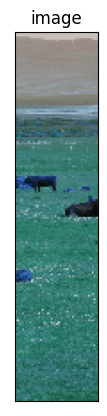

In [10]:


sample_test_data = np.load('/home/naitri/Documents/MSRC_ObjCategImageDatabase_v1/datasets/test/1_10_s_10_.npy')

plot_image(sample_test_data, 'image')



In [11]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau



is_cuda_available = torch.cuda.is_available()
if is_cuda_available:
    print("Using CUDA")
device = torch.device("cuda:0" if is_cuda_available else "cpu")
print(device)

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):
    def __init__(self, data_path, csv_file, transform=None):
      # Your code 
      self.data = pd.read_csv(f'{data_path}/{csv_file}', skiprows=1, header=None)
      self.data_size = len(self.data)
      self.data_path = data_path
      self.transform = transform

            
    def __len__(self):
      # Your code 
      return self.data_size

    
    def __getitem__(self, index):
      # Your code 
      filename = self.data.iloc[index, 1]
      image_path = f'{self.data_path}/{filename}'
      image = np.load(image_path, allow_pickle=True)
      label_y = int(self.data.iloc[index, 2])

      data_y = torch.tensor(label_y)
      if self.transform:
        image = self.transform(image)

      return (image, label_y)


Using CUDA
cuda:0


Now, we can define the dataset and dataloader.

## Question 2: Deep Network (10 points)

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [12]:
# Simple Identity class that let's input pass without changes
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

def load_and_customize_vgg16():

  # load the pre-trained model
  vgg16 = models.vgg16(pretrained=True) 
  
  # freeze convolution weights
  for param in vgg16.features.parameters():
    param.requires_grad = False

  # customization of the last layers
  # vgg16.avgpool = Identity()
  # Add on classifier
  n_inputs = vgg16.classifier[6].in_features
  n_outputs = 10
  vgg16.classifier[6] = nn.Sequential(
                        nn.Linear(n_inputs, 256), 
                        nn.ReLU(inplace=True), 
                        nn.Dropout(0.5),
                        nn.Linear(256, n_outputs))
  
  
  return vgg16


# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):  
      # Your code 
      super(SegmentationNN, self).__init__()
      
      # load the pre-trained model
      self.model = load_and_customize_vgg16()
      self.model.to(device)
      print(self.model)
      

    def forward(self, x):

      # Your code 
      # pass
      x = self.model(x)
      return x

## Question 3: Optimizer (10 points) 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [13]:
import time
# Optimizer 
class Solver(object):
    def __init__(self, model, learning_rate=LEARNING_RATE):
      # Your code 
      # pass
      self.model = model
      self.criterion = nn.CrossEntropyLoss()
      self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
      # Define Scheduler
      self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.1, patience=5, verbose=True
      )
      self.epoch_acc = []
      self.epoch_loss = []
      self.running_loss = []
      self.running_acc = []

    def train(self, data_loader):
        # Your code 
        self.model.train()
        start = time.process_time()
        self.epoch_acc = []
        self.epoch_loss = []
        self.running_loss = []
        self.running_acc = []

        for epoch in range(NUM_EPOCH):
          losses = []
          running_loss = 0
          running_corrects = 0
          num_samples = 0
          
          batch_loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=True)
          for idx, (image, labels) in batch_loop:

            image = image.to(device=device)
            #print(image[0].size)
            labels = labels.to(device=device)

            # forward
            predicted_labels = self.model(image)
            _, preds = torch.max(predicted_labels, 1)

            loss = self.criterion(predicted_labels, labels)

            losses.append(loss.item())

            running_corrects += torch.sum(preds == labels)
            num_samples += predicted_labels.size(0)


            # backward
            self.optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            self.optimizer.step()

            batch_loop.set_description(f'Epoch [{epoch}/{NUM_EPOCH}]')
            batch_loop.set_postfix(loss=loss.item(), acc=(running_corrects/num_samples).item())

            self.running_loss.append(sum(losses)/len(losses))
          
          avg_loss = sum(losses)/len(losses)
          avg_acc = running_corrects/num_samples
          self.scheduler.step(avg_loss)

          self.epoch_acc.append(avg_acc)
          self.epoch_loss.append(avg_loss)

          time_elapsed = time.process_time() - start
          print('Epoch: [{}/{}] Time: {}min:{}sec Training Loss: {:.4f} Acc: {:.4f}'.format(epoch, NUM_EPOCH, time_elapsed//60, time_elapsed%60, avg_loss, avg_acc))


          #self.scheduler()
    
    def evaluate(self, data_loader):
        self.model.eval()

        self.epoch_acc = []
        self.epoch_loss = []
        self.running_loss = []
        self.running_acc = []
        start = time.process_time()

        for epoch in range(NUM_EPOCH):
          losses = []
          running_loss = 0
          running_corrects = 0
          num_samples = 0
          
          batch_loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=True)
          with torch.no_grad():
            for idx, (image, labels) in batch_loop:
              image = image.to(device=device)
              labels = labels.to(device=device)

              # forward
              predicted_labels = self.model(image)
              _, preds = torch.max(predicted_labels, 1)

              running_corrects += torch.sum(preds == labels)
              num_samples += predicted_labels.size(0)

              batch_loop.set_description(f'Epoch [{epoch}/{NUM_EPOCH}]')
              batch_loop.set_postfix(acc=(running_corrects/num_samples).item())

          avg_acc = running_corrects/num_samples

          self.epoch_acc.append(avg_acc)

          time_elapsed = time.process_time() - start
          print('Epoch: [{}/{}] Time: {}min:{}sec Training Acc: {:.4f}'.format(epoch, NUM_EPOCH, time_elapsed//60, time_elapsed%60, avg_acc)) 

## Question 4: Putting it together (50 points) 

Start to train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

1. Randomly split the whole dataset into train and test subset (80:20 split is fine), show us the training loss of the classifier after every epoch, and then training accuracy and test accuracy of the classifier after training.
2. At least one visualization on the test segmentation map vs. ground truth segmentation map.

In [14]:


custom_transforms = transforms.Compose([
        transforms.ToPILImage(),
        #transforms.Resize((256, 256)),
        #transforms.RandomCrop((224,224)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
        ])

# load the data
train_dataset = SegmentationData(train_path, TRAIN_CSVFILE, custom_transforms)
test_dataset = SegmentationData(test_path, TEST_CSVFILE, custom_transforms)


# data loader
train_data_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_data_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

dataiter = iter(train_data_loader)
data_samp = dataiter.next()
print(data_samp[0][0].shape)



torch.Size([3, 224, 224])


In [15]:


# model
model = SegmentationNN()

# train the model
solver = Solver(model, LEARNING_RATE)

# start training 
solver.train(train_data_loader)
print('Training Done!')



# solver.evaluate(test_data_loader)
# print('testing Done!')





VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch [0/5]: 100%|█████| 723/723 [01:36<00:00,  7.46it/s, acc=0.815, loss=0.657]

Epoch: [0/5] Time: 1.0min:37.58635389400001sec Training Loss: 0.5377 Acc: 0.8154



Epoch [1/5]: 100%|████| 723/723 [01:31<00:00,  7.88it/s, acc=0.928, loss=0.0693]

Epoch: [1/5] Time: 3.0min:10.157856949999996sec Training Loss: 0.2184 Acc: 0.9283



Epoch [2/5]: 100%|█████| 723/723 [01:31<00:00,  7.90it/s, acc=0.96, loss=0.0136]

Epoch: [2/5] Time: 4.0min:42.423220388999994sec Training Loss: 0.1203 Acc: 0.9603



Epoch [3/5]: 100%|█████| 723/723 [01:34<00:00,  7.63it/s, acc=0.972, loss=0.405]

Epoch: [3/5] Time: 6.0min:17.997568564000062sec Training Loss: 0.0820 Acc: 0.9719



Epoch [4/5]: 100%|███| 723/723 [01:43<00:00,  7.02it/s, acc=0.979, loss=0.00359]

Epoch: [4/5] Time: 8.0min:2.0864087910000535sec Training Loss: 0.0664 Acc: 0.9789
Training Done!


In [16]:

solver.evaluate(test_data_loader)
print('testing Done!')

Epoch [0/5]: 100%|█████████████████| 180/180 [00:14<00:00, 12.45it/s, acc=0.855]

Epoch: [0/5] Time: 0.0min:14.616169749999926sec Training Acc: 0.8549



Epoch [1/5]: 100%|█████████████████| 180/180 [00:15<00:00, 11.86it/s, acc=0.855]

Epoch: [1/5] Time: 0.0min:30.13994779199993sec Training Acc: 0.8549



Epoch [2/5]: 100%|█████████████████| 180/180 [00:15<00:00, 11.83it/s, acc=0.855]

Epoch: [2/5] Time: 0.0min:45.68039104199988sec Training Acc: 0.8549



Epoch [3/5]: 100%|█████████████████| 180/180 [00:14<00:00, 12.24it/s, acc=0.855]


Epoch: [3/5] Time: 1.0min:0.6566430779998882sec Training Acc: 0.8549


Epoch [4/5]: 100%|█████████████████| 180/180 [00:13<00:00, 13.06it/s, acc=0.855]


Epoch: [4/5] Time: 1.0min:14.622634500000004sec Training Acc: 0.8549
testing Done!


In [17]:
def get_cropped_image(seg_map, seg_label, sample_image):
  rect_patch_loc = get_rect_patch_loc(seg_map, seg_label)
  if rect_patch_loc is not None:
    sample_im_cropped = crop_image(sample_image, rect_patch_loc)
    return sample_im_cropped
  return None
    

In [ ]:
## Testing the model
list_files = os.listdir(msrc_directory)
total_images = len(list_files)
TRAIN_SIZE = int(len(list_files) * 0.8)
TEST_SIZE = total_images - TRAIN_SIZE
testing_files = list_files[TRAIN_SIZE:]

# select a random image file from the test data:
filename = testing_files[14]
i = 50
while not (BMP_EXT in filename and GT not in filename):
      i += 1
      filename = testing_files[i]

print(filename)
test_sample_filename = filename
test_gt_filename = filename.replace(BMP_EXT, (GT+BMP_EXT))

test_sample_filename = os.path.join(msrc_directory, test_sample_filename)
test_gt_filename = os.path.join(msrc_directory, test_gt_filename)

test_sample_image = cv2.imread(test_sample_filename)
test_gt_image = cv2.imread(test_gt_filename)

test_sample_image = test_sample_image[:,:,::-1]   # bgr to rgb
test_gt_image = test_gt_image[:,:,::-1]           # bgr to rgb

seg_map = slic(test_sample_image, n_segments=NUM_SLIC_SEG, compactness=10)
slic_label_to_seg_class_map = {}
predicted_seg = np.zeros(test_sample_image.shape)
model.eval()
for i in range(NUM_SLIC_SEG):
  cropped_image = get_cropped_image(seg_map, i, test_sample_image)
  if cropped_image is not None:
    ## predict_label = model.
    # forward
    cropped_image = custom_transforms(cropped_image).to(device)
    cropped_image = cropped_image.unsqueeze(0) 
    predicted_labels = model(cropped_image)

    _, preds = torch.max(predicted_labels, 1)
    slic_label_to_seg_class_map[i] = preds.item() - 1  #original labels were from -1

    ind = (seg_map == i)
    predicted_seg[ind] = label_2_rgb[preds.item()-1]
  else:
    break
    # print(i, 'Not found')
    

plot_image(test_sample_image, 'input_image')
plot_image(predicted_seg, 'predicted_segement')
plot_image(test_gt_image, 'seg_ground truth')

## Bonus Questions (20 points):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

In [ ]:
#TODO: Bonus


